In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from src.constant import PROCESSED_DATA_DIR
from src.split import get_n_splits, permutate_df_by_cost_decreasing

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

In [3]:
evaluations_df = pd.read_parquet(PROCESSED_DATA_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DATA_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DATA_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,cost,ALGORITHM,CMA_ELITIST,CMA_POPSIZE,CMA_POPSIZE_FACTOR,CMA_RANDOM_INIT,CMA_SCALE,DE_CROSSOVER,...,pca_expl_var_PC1_cor_x,pca_expl_var_PC1_cov_init,pca_expl_var_PC1_cor_init,pca_costs_runtime,ic_h_max,ic_eps_s,ic_eps_max,ic_eps_ratio,ic_m0,ic_costs_runtime
0,410950163550714701,1459556901948702861,0.364175,0.0,1.0,0.955556,0.410492,1.0,0.972919,0.081101,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
1,1743092914995070369,1459556901948702861,0.398162,0.0,1.0,0.600000,0.246063,1.0,0.447144,0.449083,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
2,2283111023303066572,1459556901948702861,0.055367,1.0,0.0,0.244444,0.426904,1.0,0.406922,0.772266,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
3,2253826169615980878,1459556901948702861,0.808347,1.0,1.0,0.111111,0.118728,1.0,0.916723,0.842342,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
4,1589992703076004730,1459556901948702861,0.572030,1.0,1.0,0.700000,0.884952,1.0,0.751022,0.878372,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,1090844655874379195,1903964392399407975,300.000000,0.0,1.0,0.222222,0.604851,0.0,0.259828,0.415285,...,0.062206,0.990413,0.067438,0.269816,0.868371,1.546547,5.568596,0.995996,0.627756,21.302308
119996,686048789577017900,1903964392399407975,300.000000,0.0,0.0,0.744444,0.570018,0.0,0.793826,0.983013,...,0.062206,0.990413,0.067438,0.269816,0.868371,1.546547,5.568596,0.995996,0.627756,21.302308
119997,243020324673513847,1903964392399407975,300.000000,0.0,1.0,0.644444,0.531420,0.0,0.071196,0.581472,...,0.062206,0.990413,0.067438,0.269816,0.868371,1.546547,5.568596,0.995996,0.627756,21.302308
119998,708619547354767275,1903964392399407975,300.000000,0.0,0.0,0.233333,0.384026,0.0,0.714490,0.829189,...,0.062206,0.990413,0.067438,0.269816,0.868371,1.546547,5.568596,0.995996,0.627756,21.302308


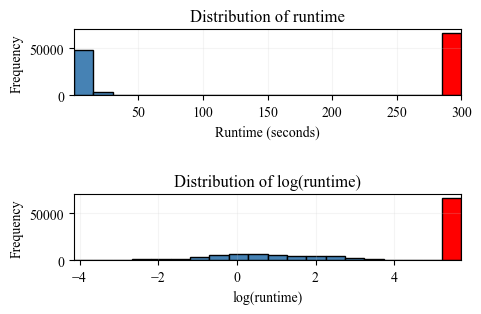

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 3))

n, bins_edges, patches = ax1.hist(
    df["cost"],
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches[-1].set_facecolor('red') 

ax1.set_title('Distribution of runtime')
ax1.set_xlabel('Runtime (seconds)')
ax1.set_ylabel('Frequency')

n2, bins_edges2, patches2 = ax2.hist(
    np.log(df["cost"] + 0.01),
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches2[-1].set_facecolor('red') 

ax2.set_title('Distribution of log(runtime)')
ax2.set_xlabel('log(runtime)')
ax2.set_ylabel('Frequency')

plt.subplots_adjust(hspace=1.5)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
# plt.savefig("fig.pdf", bbox_inches="tight")
plt.show()

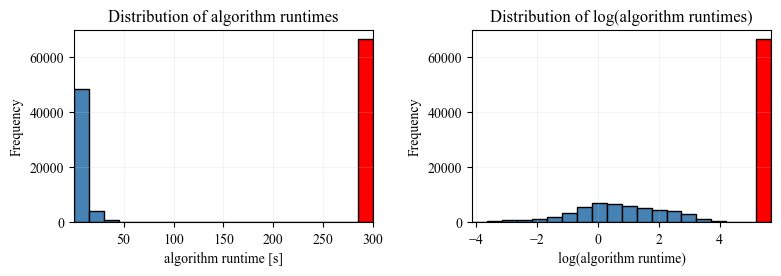

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5))

n, bins_edges, patches = ax1.hist(
    df["cost"],
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches[-1].set_facecolor("red")

ax1.set_title("Distribution of algorithm runtimes")
ax1.set_xlabel("algorithm runtime [s]")
ax1.set_ylabel("Frequency")

n2, bins_edges2, patches2 = ax2.hist(
    np.log(df["cost"] + 0.01),
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches2[-1].set_facecolor("red")

ax2.set_title("Distribution of log(algorithm runtimes)")
ax2.set_xlabel("log(algorithm runtime)")
ax2.set_ylabel("Frequency")

plt.subplots_adjust(wspace=0.33)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
# plt.savefig("fig.pdf", bbox_inches="tight")
plt.show()

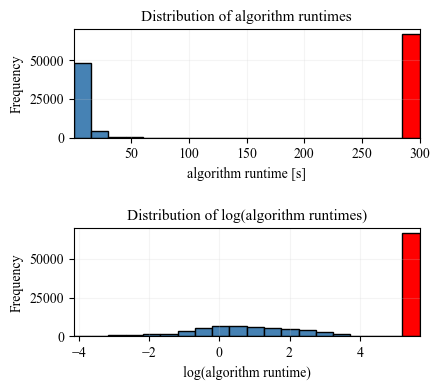

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 4))

n, bins_edges, patches = ax1.hist(
    df["cost"],
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches[-1].set_facecolor("red")

ax1.set_title("Distribution of algorithm runtimes", fontsize=11)
ax1.set_xlabel("algorithm runtime [s]")
ax1.set_ylabel("Frequency")

n2, bins_edges2, patches2 = ax2.hist(
    np.log(df["cost"] + 0.01),
    bins=20,
    color="steelblue",
    edgecolor="black",
)

patches2[-1].set_facecolor("red")

ax2.set_title("Distribution of log(algorithm runtimes)", fontsize=11)
ax2.set_xlabel("log(algorithm runtime)")
ax2.set_ylabel("Frequency")

plt.tight_layout(h_pad=2)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
# plt.savefig("fig.pdf", bbox_inches="tight")
plt.show()

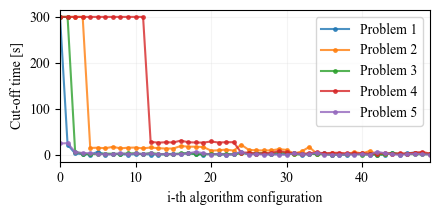

In [7]:
train_idx, test_idx = get_n_splits(df, n=2, instance_number=5, solver_number=100, random_state=0)[0]

df_train_test = df.loc[np.concatenate([train_idx, test_idx])]

df_train_test, cut_off_train_test = permutate_df_by_cost_decreasing(
    df_train_test, 
    lognormal_mean=0,
    lognormal_sigma=1,
    random_state=9
)

is_train = df_train_test.index.isin(train_idx)
is_test = df_train_test.index.isin(test_idx)

df_train = df_train_test.loc[is_train]
cut_off_train = cut_off_train_test[is_train]
df_test = df_train_test.loc[is_test]
cut_off_test = cut_off_train_test[is_test]


fig, ax = plt.subplots(figsize=(4.5, 2.25))
for i in range(5):
    ax.plot(cut_off_test[i::5], label=f"Problem {i+1}", marker=".", markersize=5, linestyle="-", alpha=0.8)

ax.legend()
ax.set_xlabel("i-th algorithm configuration")
ax.set_ylabel("Cut-off time [s]")
plt.tight_layout()
# ax.set_title("Cut-off time for 5 problem instances and for 50 solvers")
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
# plt.savefig("fig.pdf", bbox_inches="tight")
plt.show()